In [ ]:
 import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import math
import yaml
from torch.utils.data.dataloader import DataLoader
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
from scipy.spatial.distance import cdist

In [ ]:
ROOT = 'C:\\Users\\curea\\Documents\\bioFM for drug discovery\\dege-fm\\'

In [ ]:
with open(ROOT + "data\\sciplex\\drugs_train_list.txt", "r") as f:
    drugs_train = [line.strip() for line in f]

with open(ROOT + "data\\sciplex\\drugs_validation_list.txt", "r") as f:
    drugs_validation = [line.strip() for line in f]


adata = ad.read_h5ad(ROOT + "data\\sciplex\\sciplex_preprocessed.h5ad")

In [ ]:
adata

In [ ]:
for drug in drugs_train:
    if drug in drugs_validation:
        print(drug)

In [ ]:
results = dict()

for drug in tqdm(list(adata.obs['product_name'].unique())):
    for cell_type in list(adata.obs['cell_type'].unique()):
        adata_subset = adata[adata.obs['cell_type'] == cell_type]
        adata_subset = adata_subset[adata_subset.obs['product_name'] == drug]

        if adata_subset.n_obs == 0:
            continue

        row_sums = adata_subset.X.sum(axis=0)      # Sum along rows
        row_sums = np.squeeze(np.asarray(row_sums))  # Sum along rows, convert result to a flat array
        n_cols = adata_subset.X.shape[1]          # Number of columns
        centroid = row_sums / n_cols

        key = drug + "_" + cell_type

        results[key] = centroid

In [ ]:
for i in list(results.values()):
    print(type(i))
    print(len(i))

In [ ]:
ids = list(results.keys())
centroids = np.array(list(results.values()))

# Calculate pairwise Euclidean distances
distances = cdist(centroids, centroids, metric='euclidean')

In [28]:
distances

array([[0.        , 0.60626005, 0.32202548, ..., 0.13432468, 0.46150887,
        0.33100519],
       [0.60626005, 0.        , 0.64653073, ..., 0.66867229, 0.22041777,
        0.67947651],
       [0.32202548, 0.64653073, 0.        , ..., 0.30588297, 0.49789581,
        0.07882485],
       ...,
       [0.13432468, 0.66867229, 0.30588297, ..., 0.        , 0.49263211,
        0.28827861],
       [0.46150887, 0.22041777, 0.49789581, ..., 0.49263211, 0.        ,
        0.51643641],
       [0.33100519, 0.67947651, 0.07882485, ..., 0.28827861, 0.51643641,
        0.        ]])

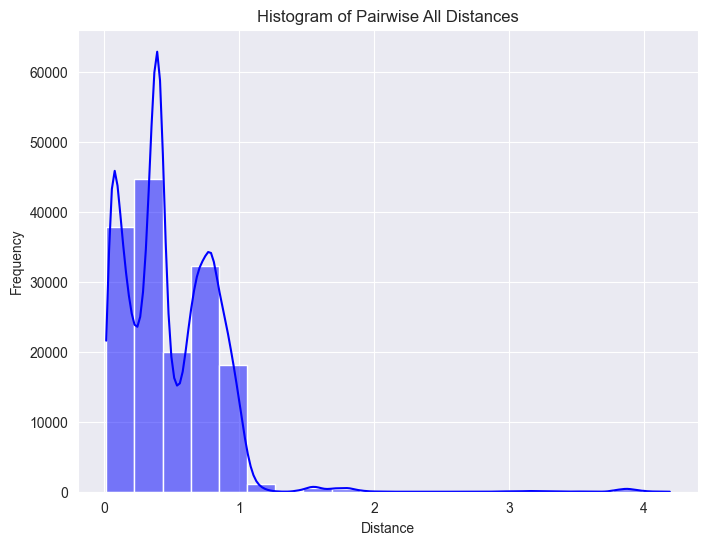

In [31]:
pairwise_distances = distances[np.triu_indices_from(distances, k=1)]  # Upper triangular without diagonal

# Plot the histogram of pairwise distances
plt.figure(figsize=(8, 6))
sns.histplot(pairwise_distances, bins=20, kde=True, color='blue')
plt.title("Histogram of Pairwise All Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap

In [41]:
centroids = np.array(list(results.values()))
keys = list(results.keys())

obs = pd.DataFrame({"key": keys})

adata_centroids = ad.AnnData(X=centroids, obs=obs)

C:\Users\curea\anaconda3\envs\dege-fm\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [44]:
drug = [x.split("_")[0] for x in list(adata_centroids.obs['key'])]
adata_centroids.obs['drug'] = drug

cell_type = [x.split("_")[1] for x in list(adata_centroids.obs['key'])]
adata_centroids.obs['cell_type'] = cell_type

train = [True if x in drugs_train else False for x in list(adata_centroids.obs['drug'])]
adata_centroids.obs['train'] = train

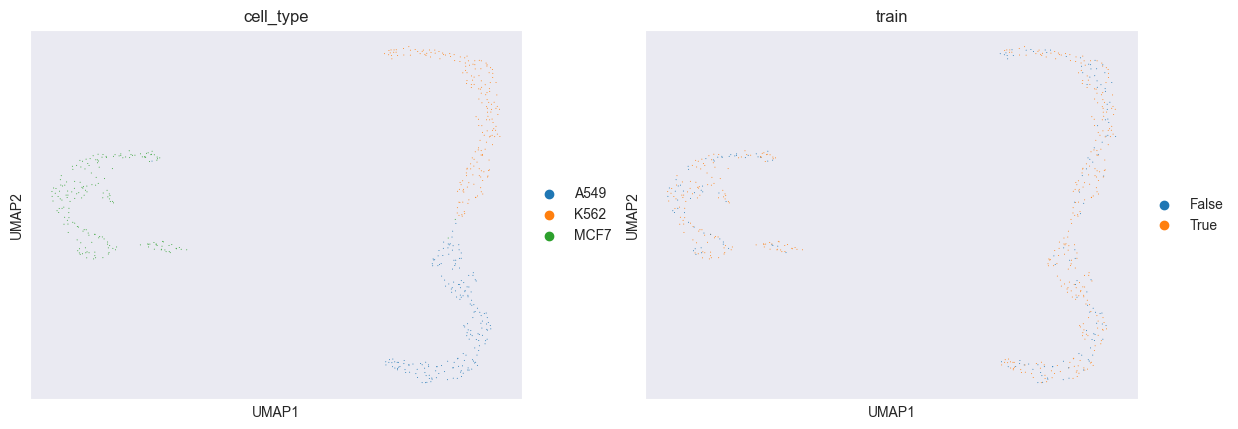

In [48]:
import scanpy as sc

sc.pp.neighbors(adata_centroids, use_rep="X")
sc.tl.umap(adata_centroids)
sc.pl.umap(
    adata_centroids,
    color=["cell_type", "train"],
    size=2,
)